<div class="alert alert-block alert-warning">
<b>Disclaimer:</b> The main objective of the jupyter notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function
- setting and run the fit   
- extracting and displaying information about the results

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.
</div>


<h1> Example: Composition of Lorentzian and Isotropic Rotational diffusion models convoluted with resolution function and fitted with bumps </h1>

<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#set_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a>

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use a combination of models from the QENS library <em>i.e.</em> <b>Lorentzian</b>  and <b>IsotropicRotationalDiffusion</b> models.
</div>

The data are a set of water data measured at IN5 (ILL).

**Reference:** J. Qvist, H. Schober and B. Halle, *J. Chem. Phys.* **134**, 144508 (2011)

### Physical units
For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

#matplotlib inline

# for interactive plots
import panel
panel.extension()
import panel.widgets as pnw

# the following two lines are to remove the warning about too many figures open simultaneously
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    bumpsY = pnw.Button(name='Yes', button_type='success')
    bumpsN = pnw.Button(name='No', button_type='danger')
    choice_installation = panel.Column("Do you want to install bumps?", panel.Row(bumpsY, bumpsN))
    display(choice_installation)

In [3]:
if not pkgutil.find_loader("bumps"):
    if bumpsY.clicks>0:
        !{sys.executable} -m pip install bumps
    elif bumpsN.clicks>0:
        print("You will not be able to run some of the remaining parts of this notebook")

In [4]:
import bumps

In [5]:
# check version of bumps installed
# Information message if installed version not recent enough
from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

 (<a href='#Table of Contents'>Top</a>)<a id='set_fitting'></a><h2>Setting of fitting </h2>
<h3> install QENSmodels (if not already installed) </h3>

In [6]:
if not pkgutil.find_loader("QENSmodels"):
    buttonY = pnw.Button(name='Yes', button_type='success')
    buttonN = pnw.Button(name='No', button_type='danger')
    choice_installation = panel.Column("Do you want to install the QENSmodels' library?", panel.Row(buttonY, buttonN))
    display(choice_installation)

In [7]:
if not pkgutil.find_loader("QENSmodels"):
    if buttonY.clicks>0:
        !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels
    elif buttonN.clicks>0:
        print("You will not be able to run some of the remaining parts of this notebook")

<h3> import reference data </h3>

In [8]:
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

path_to_data = './data/'

# Data
# Wavelength 5 Angstrom
with h5py.File(path_to_data + 'H2O_293K_5A.hdf', 'r') as f:
    hw_5A = f['entry1']['data1']['X'][:]
    q_5A = f['entry1']['data1']['Y'][:]
    unit_w5A = f['entry1']['data1']['X'].attrs['long_name']
    unit_q5A = f['entry1']['data1']['Y'].attrs['long_name']
    sqw_5A = np.transpose(f['entry1']['data1']['DATA'][:])
    err_5A = np.transpose(f['entry1']['data1']['errors'][:])

# Resolution
# Wavelength 5 Angstrom
with h5py.File(path_to_data + 'V_273K_5A.hdf', 'r') as f:
    res_5A = np.transpose(f['entry1']['data1']['DATA'][:])

# Force resolution function to have unit area
# Wavelength 5 Angstrom
for i in range(len(q_5A)):
    area = simps(res_5A[:, i], hw_5A)
    res_5A[:, i] /= area

# Fit range -1 to +1 meV
idx_5A = np.where(np.logical_and(hw_5A > -1.0, hw_5A < 1.0))

# Fitting model
def model_convol(x, q, scale=1, center=0, hwhm=1, radius=1, DR=1, resolution=None):
    model = QENSmodels.lorentzian(x, scale, center, hwhm) + QENSmodels.sqwIsotropicRotationalDiffusion(x, q, scale, center, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

<h3> display units of input data </h3>
Just for information in order to determine if a convertion of units is required before using the QENSmodels

In [9]:
print("At 5 Angstroms, the names and units of `w` ( `x`axis) and `q` are: {} and {}, respectively.".format(str(unit_w5A[0], 'utf-8'), str(unit_q5A[0], 'utf-8')))

At 5 Angstroms, the names and units of `w` ( `x`axis) and `q` are:  Energy Transfer (meV) and Wavevector Transfer (A!U-1!N), respectively.


<h3> create fitting model </h3>

In [10]:
# Fit
M = []

for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A, i]

    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]

    # model
    Mq = Curve(model_convol, x, data, error, q=q_5A[i], scale=40,
               center=0.0, hwhm=0.1, radius=0.98, DR=0.5, resolution=resol)

    # Fitted parameters
    Mq.scale.range(0, 1e2)
    Mq.center.range(-0.1, 0.1)
    Mq.hwhm.range(0., 1)
    Mq.radius.range(0.9, 1.1)
    Mq.DR.range(0, 5)

    # Q-independent parameters
    if i == 0:
        Qhwhm = Mq.hwhm
        QR = Mq.radius
        QDR = Mq.DR
    else:
        Mq.hwhm = Qhwhm
        Mq.radius = QR
        Mq.DR = QDR

    M.append(Mq)

problem = FitProblem(M)

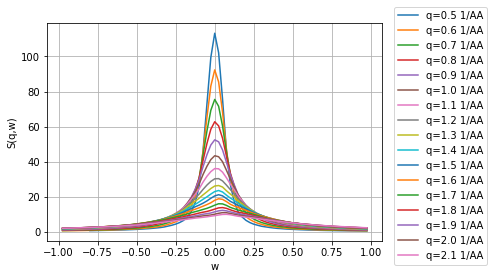

In [11]:
for i in range(len(q_5A)):

    x = hw_5A[idx_5A]
    data = sqw_5A[idx_5A, i]
    error = err_5A[idx_5A, i]
    resol = res_5A[idx_5A, i]

    # Select only valid data (error = -1 for Q, w points not accessible)
    valid = np.where(error > 0.0)
    x = x[valid[1]]
    data = data[valid]
    error = error[valid]
    resol = resol[valid]
    plt.grid()
    plt.xlabel("w")
    plt.ylabel("S(q,w)")
    plt.plot(x, data, label="q={:1.1f} 1/AA".format(q_5A[i]))
    
    plt.legend(bbox_to_anchor=(1.02,1.1), loc="upper left")
    
plt.show()

#### Choice of minimizers

In [12]:
options_dict={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"}

w_choice_minimizer= pnw.Select(name='Minimizer:', options=list(options_dict.keys()), value='Levenberg-Marquardt')

w_choice_minimizer

Select(name='Minimizer:', options=['Levenberg-Marquardt', ...], value='Levenberg-Marquardt')

<h3> Setting for running bumps </h3>

In [13]:
# CHOICE OF MINIMIZER
chosen_minimizer = options_dict[w_choice_minimizer.value]

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

Initial chisq 644147.207(31)


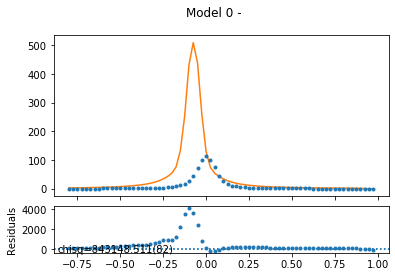

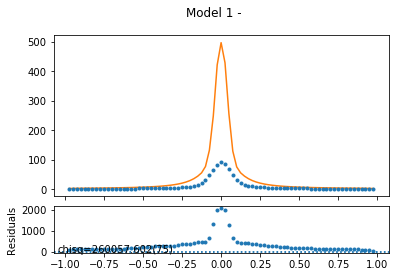

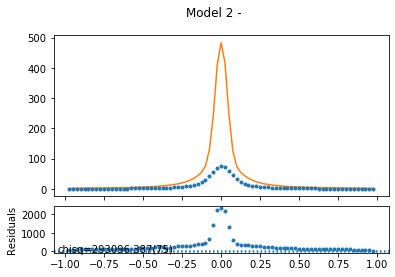

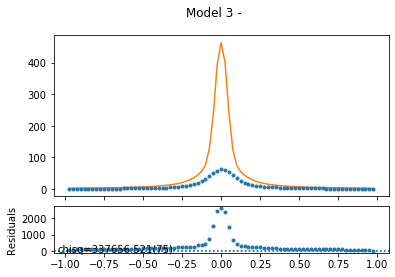

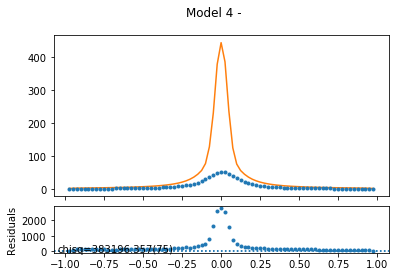

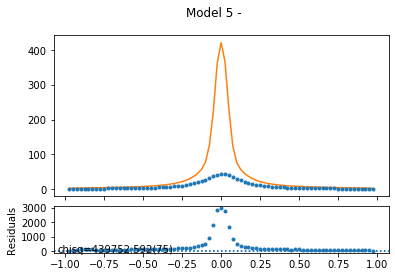

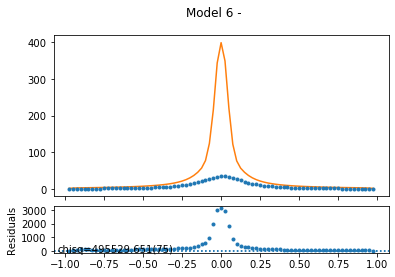

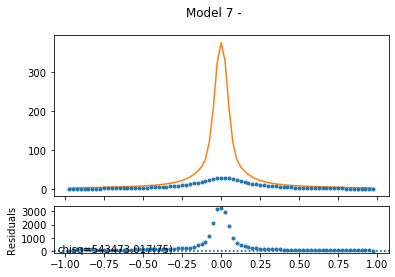

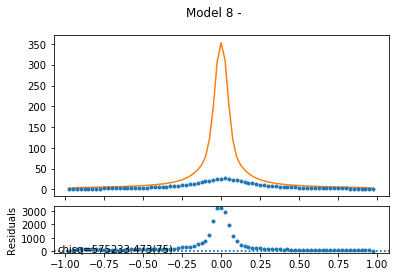

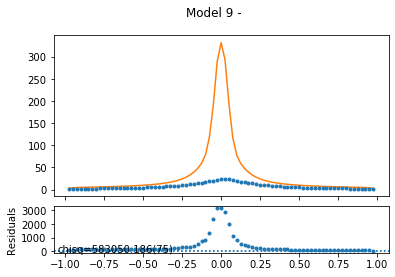

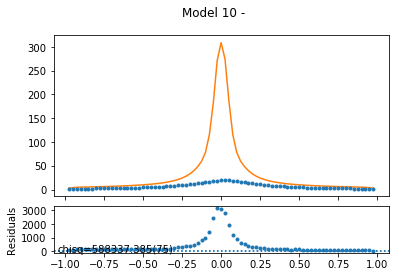

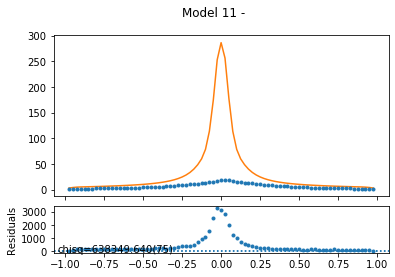

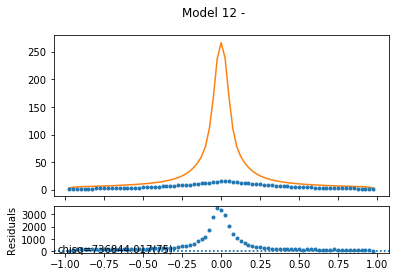

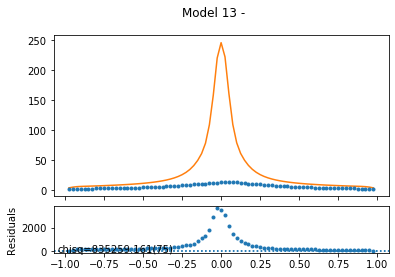

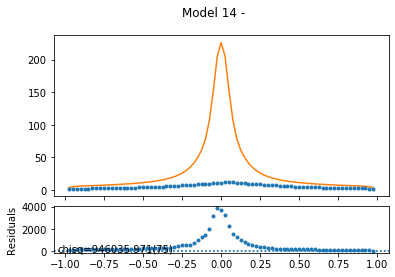

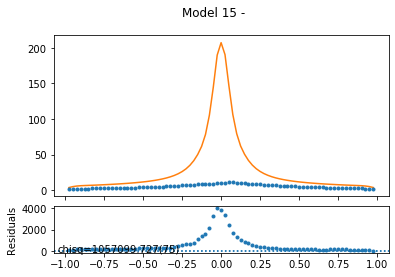

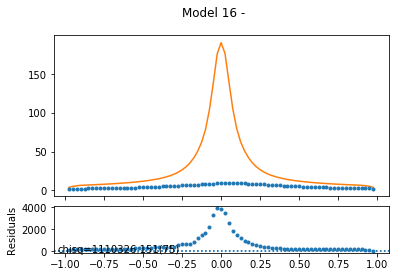

In [14]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())
problem.plot()

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above.

In [15]:
result = fit(problem, 
             method=chosen_minimizer, 
             steps=steps, verbose=True)

final chisq 6355.640(31)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                                      DR 0.20881(62)     0.2088150(78)  
                                  center 0.03466(27)     0.0346597(34)  
                                    hwhm 0.12677(12)     0.1267705(15)  
                                  radius 1.0998998862(67) 1.099899886208(84)
                                   scale 7.0631(61)      7.063064(76)   
                                  center 0.00169(19)     0.0016949(24)  
                                   scale 9.9285(67)      9.928471(84)   
                                  center 0.00172(22)     0.0017245(27)  
                                   scale 9.5284(67)      9.528361(84)   
                                  center 0.00205(23)     0.0020541(29)  
                                   scale 9.0684(65)      9.068378(82)   
                                  center 0.00186(25)     0.0018588(31)  
                 

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

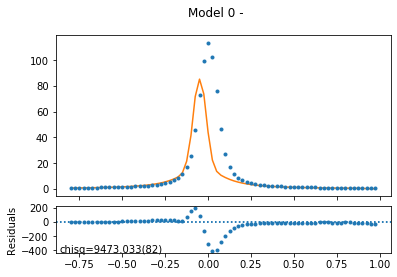

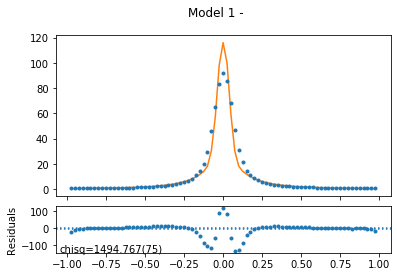

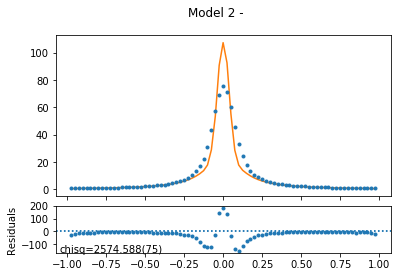

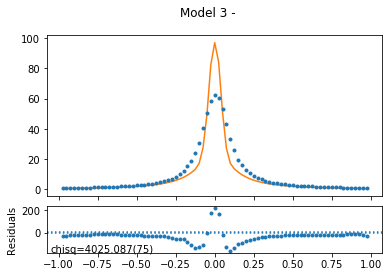

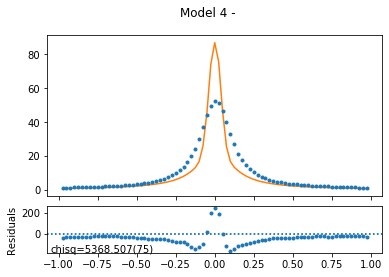

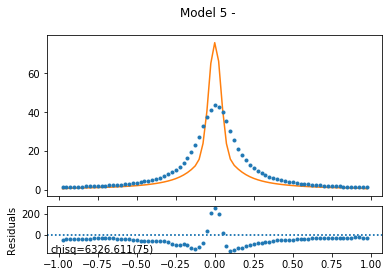

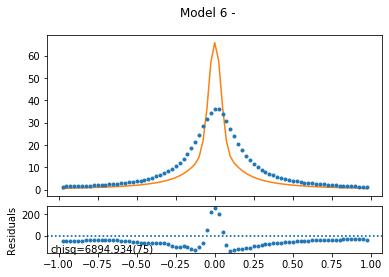

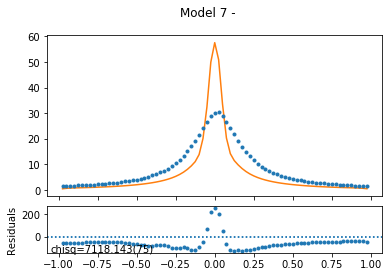

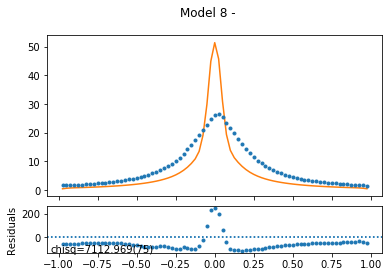

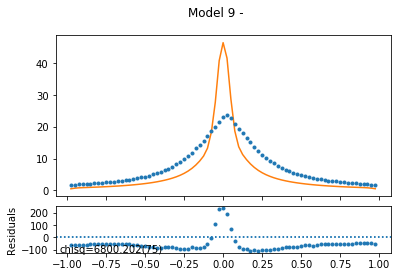

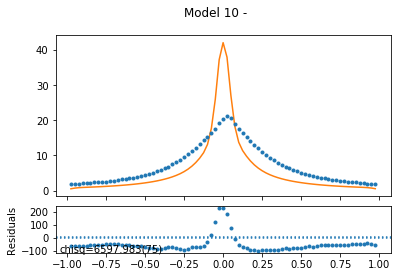

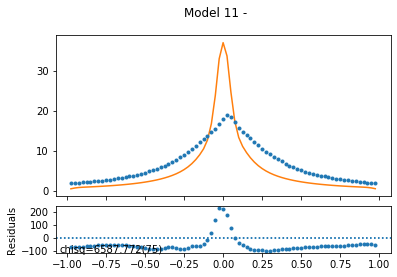

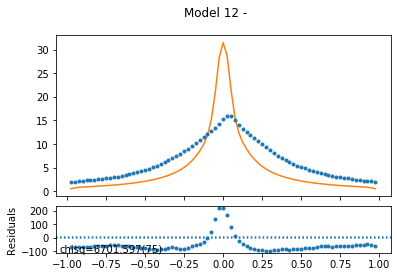

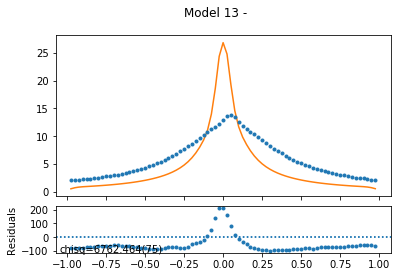

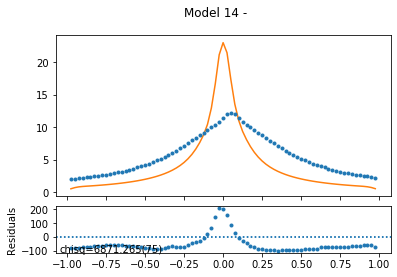

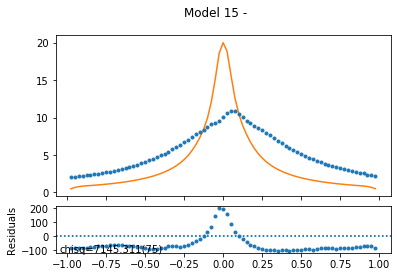

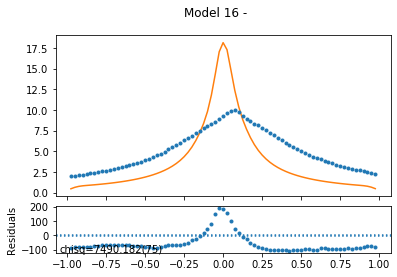

In [16]:
problem.plot()

In [17]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(k, ":", format_uncertainty(v, dv))

final chisq 6355.640(31)
DR : 0.20881(62)
center : 0.03466(27)
hwhm : 0.12677(12)
radius : 1.0998998862(67)
scale : 7.0631(61)
center : 0.00169(19)
scale : 9.9285(67)
center : 0.00172(22)
scale : 9.5284(67)
center : 0.00205(23)
scale : 9.0684(65)
center : 0.00186(25)
scale : 8.5818(63)
center : 0.00175(27)
scale : 7.9689(61)
center : 0.00182(27)
scale : 7.4031(60)
center : 0.00304(28)
scale : 6.9408(59)
center : 0.00310(28)
scale : 6.6976(58)
center : 0.00365(27)
scale : 6.5440(59)
center : 0.00448(26)
scale : 6.4580(59)
center : 0.00470(25)
scale : 6.2199(58)
center : 0.00436(25)
scale : 5.7765(56)
center : 0.00465(25)
scale : 5.3943(53)
center : 0.00463(25)
scale : 5.0998(52)
center : 0.00470(24)
scale : 4.8614(50)
center : 0.00455(23)
scale : 4.8172(49)
